# 06 — Training v3 (Architecture Alignment + Augmented Data)

Perbaikan arsitektur sesuai paper Wang et al. (2021):
1. **Cross-Attention ASD** — h_ae attend ke h_sl dengan relative position encoding (Eq. 7-9)
2. **Prior Embedding** — Word frequency distribution sebagai prior knowledge untuk ATE (Sec. 3.1.4)
3. **Sentiment Connection** — Pre-train SLD, lalu copy weights ke ASD classifier (Sec. 3.1.5)

| Setting | v1 (Baseline) | v2 (Hyp. Tuning) | v3 (Paper-aligned) |
|---|---|---|---|
| Data | 2,451 | 2,451 | **Augmented (~4,300 train)** |
| Architecture | Cross-attn + Prior + SC | Cross-attn + Prior + SC | Cross-attn + Prior + SC |
| Dropout | 0.1 | 0.3 | **0.2** |
| Weight Decay | 0.01 | 0.05 | **0.03** |
| Freeze Layers | 0/24 | 18/24 | **12/24** |
| Early Stopping | Tidak | patience=5 | **patience=5** |
| ASD Class Weight | Tidak | Ya | **Tidak** (augmentasi handle imbalance) |
| Loss Weighting | Paper: λ1=0.3, λ2=0.3 | Paper: λ1=0.3, λ2=0.3 | Paper: λ1=0.3, λ2=0.3 |

In [1]:
import json
import os
import string
import time
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from torchcrf import CRF
from seqeval.metrics import classification_report, f1_score as seq_f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch: {torch.__version__}')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

PyTorch: 2.5.1+cu121
Device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
VRAM: 8.0 GB


### 1. KONFIGURASI

In [2]:
# Paths
BASE_DIR = os.path.dirname(os.getcwd())
DATA_RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
DATA_PROC_DIR = os.path.join(BASE_DIR, 'data', 'processed')
MODEL_DIR = os.path.join(BASE_DIR, 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

# PRE-SPLIT data dari NB 05 (augmentasi hanya pada train, val tetap original)
TRAIN_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos_augmented_train.json')
VAL_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos_val.json')
POS_LEX_PATH = os.path.join(DATA_RAW_DIR, 'indonesian_sentiment_lexicon_positive.tsv')
NEG_LEX_PATH = os.path.join(DATA_RAW_DIR, 'indonesian_sentiment_lexicon_negative.tsv')

# Model
MODEL_NAME = 'indobenchmark/indobert-large-p2'
MAX_LENGTH = 128
PROJ_DIM = 256

# Training — MODERATE (between v1 and v2)
BATCH_SIZE = 4
GRADIENT_ACCUMULATION = 4  # effective batch = 16
NUM_EPOCHS = 30
LR_BERT = 2e-5
LR_HEAD = 1e-4
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.03        # v1: 0.01, v2: 0.05 -> v3: 0.03
MAX_GRAD_NORM = 1.0
SEED = 42

# Moderate regularization
DROPOUT = 0.2              # v1: 0.1, v2: 0.3 -> v3: 0.2
FREEZE_LAYERS = 12         # v1: 0, v2: 18 -> v3: 12 (freeze 50%)
EARLY_STOP_PATIENCE = 5

# Architecture (Paper-aligned)
PHASE1_EPOCHS = 3           # SLD pre-training for Sentiment Connection
LAMBDA1 = 0.3               # Paper Eq. 10: weight for L_ae + L_sl
LAMBDA2 = 0.3               # Paper Eq. 10: weight for L_sd
MAX_REL_POS = 20            # Max relative position for cross-attention

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f'Model       : {MODEL_NAME}')
print(f'Data        : PRE-SPLIT (augmented train + original val)')
print(f'Batch size  : {BATCH_SIZE} x {GRADIENT_ACCUMULATION} accum = {BATCH_SIZE * GRADIENT_ACCUMULATION} effective')
print(f'Training    : Phase 1 ({PHASE1_EPOCHS} epochs) + Phase 2 (max {NUM_EPOCHS} epochs)')
print(f'LR (BERT)   : {LR_BERT}')
print(f'LR (heads)  : {LR_HEAD}')
print(f'Weight decay: {WEIGHT_DECAY}')
print(f'Dropout     : {DROPOUT}')
print(f'Freeze BERT : {FREEZE_LAYERS}/24 layers')
print(f'Loss weight : λ1={LAMBDA1}, λ2={LAMBDA2} (paper Eq. 10)')

Model       : indobenchmark/indobert-large-p2
Data        : PRE-SPLIT (augmented train + original val)
Batch size  : 4 x 4 accum = 16 effective
Training    : Phase 1 (3 epochs) + Phase 2 (max 30 epochs)
LR (BERT)   : 2e-05
LR (heads)  : 0.0001
Weight decay: 0.03
Dropout     : 0.2
Freeze BERT : 12/24 layers
Loss weight : λ1=0.3, λ2=0.3 (paper Eq. 10)


### 2. LOAD DATA

In [3]:
# Load PRE-SPLIT data dari NB 05
# Train: augmented (original train + oversampled NEG/NEU)
# Val: original (tidak diaugmentasi, sama persis dengan NB 03 & 04)
with open(TRAIN_PATH, 'r', encoding='utf-8') as f:
    train_raw = json.load(f)
with open(VAL_PATH, 'r', encoding='utf-8') as f:
    val_raw = json.load(f)

print(f'Train data (augmented): {len(train_raw)} samples')
print(f'Val data (original)   : {len(val_raw)} samples')

# Load sentiment lexicon
def load_lexicon(path):
    words = set()
    with open(path, 'r', encoding='utf-8') as f:
        next(f)  # skip header
        for line in f:
            parts = line.strip().split('\t')
            if parts:
                word = parts[0].strip().lower()
                if ' ' not in word and len(word) > 1:
                    words.add(word)
    return words

pos_lexicon = load_lexicon(POS_LEX_PATH)
neg_lexicon = load_lexicon(NEG_LEX_PATH)

overlap = pos_lexicon & neg_lexicon
pos_lexicon -= overlap
neg_lexicon -= overlap

print(f'Positive lexicon : {len(pos_lexicon)} words')
print(f'Negative lexicon : {len(neg_lexicon)} words')
print(f'Overlap removed  : {len(overlap)} words')

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f'Tokenizer loaded : {MODEL_NAME}')

Train data (augmented): 4290 samples
Val data (original)   : 368 samples
Positive lexicon : 2288 words
Negative lexicon : 5025 words
Overlap removed  : 1081 words


Tokenizer loaded : indobenchmark/indobert-large-p2


### 3. MULTI-TASK LABEL PREPARATION

| Task | Label Scheme | Jumlah |
|---|---|---|
| **ATE** (Aspect Term Extraction) | O, B, I, E, S | 5 |
| **SLD** (Sentiment Lexicon Detection) | O, POS, NEG | 3 |
| **ASD** (Aspect Sentiment Detection) | O, POS, NEG, NEU | 4 |
| **Final** (Aspect Polarity - CRF) | O, B/I/E/S-POS/NEG/NEU | 13 |

In [4]:
# Label schemes
ate_labels = ['O', 'B', 'I', 'E', 'S']
sld_labels = ['O', 'POS', 'NEG']
asd_labels = ['O', 'POS', 'NEG', 'NEU']
bieos_labels = ['O', 'B-NEG', 'B-NEU', 'B-POS', 'E-NEG', 'E-NEU', 'E-POS',
                'I-NEG', 'I-NEU', 'I-POS', 'S-NEG', 'S-NEU', 'S-POS']

ate_label2id = {l: i for i, l in enumerate(ate_labels)}
sld_label2id = {l: i for i, l in enumerate(sld_labels)}
asd_label2id = {l: i for i, l in enumerate(asd_labels)}
bieos_label2id = {l: i for i, l in enumerate(bieos_labels)}
bieos_id2label = {i: l for l, i in bieos_label2id.items()}

IGNORE_INDEX = -100

# --- Prior Embedding: word-level ATE frequency distribution (Paper Sec. 3.1.4) ---
# Computed from TRAIN data only (no leakage from val)
word_ate_freq = {}
for d in train_raw:
    for tok, lab in zip(d['tokens'], d['labels']):
        tok_lower = tok.lower()
        if tok_lower not in word_ate_freq:
            word_ate_freq[tok_lower] = [0] * len(ate_labels)
        if lab == 'O':
            word_ate_freq[tok_lower][ate_label2id['O']] += 1
        else:
            prefix = lab.split('-')[0]
            word_ate_freq[tok_lower][ate_label2id[prefix]] += 1

default_prior = [1.0] + [0.0] * (len(ate_labels) - 1)
word_prior = {}
for word, counts in word_ate_freq.items():
    total = sum(counts)
    word_prior[word] = [c / total for c in counts] if total > 0 else default_prior

print(f'Prior vocabulary: {len(word_prior)} unique words (from train)')

# --- Helper function to process raw data into tensor dict ---
def prepare_data_dict(raw_data, tokenizer, word_prior, pos_lexicon, neg_lexicon, desc='Processing'):
    all_input_ids, all_attention_mask = [], []
    all_ate, all_sld, all_asd, all_bieos, all_crf, all_prior = [], [], [], [], [], []

    for d in tqdm(raw_data, desc=desc):
        tokens, labels = d['tokens'], d['labels']

        enc = tokenizer(tokens, is_split_into_words=True,
                        max_length=MAX_LENGTH, padding='max_length',
                        truncation=True, return_tensors='pt')
        word_ids = enc.word_ids(batch_index=0)

        ate_w, sld_w, asd_w = [], [], []
        for tok, lab in zip(tokens, labels):
            if lab == 'O':
                ate_w.append('O'); asd_w.append('O')
            else:
                prefix, sentiment = lab.split('-', 1)
                ate_w.append(prefix); asd_w.append(sentiment)

            t_clean = tok.lower().strip(string.punctuation)
            if t_clean in pos_lexicon:
                sld_w.append('POS')
            elif t_clean in neg_lexicon:
                sld_w.append('NEG')
            else:
                sld_w.append('O')

        ate_a, sld_a, asd_a, bieos_a, crf_a, prior_a = [], [], [], [], [], []
        prev_wid = None
        for wid in word_ids:
            if wid is None:
                ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
                asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
                crf_a.append(0); prior_a.append(default_prior)
            elif wid != prev_wid:
                if wid < len(tokens):
                    ate_a.append(ate_label2id[ate_w[wid]])
                    sld_a.append(sld_label2id[sld_w[wid]])
                    asd_a.append(asd_label2id[asd_w[wid]])
                    bieos_a.append(bieos_label2id[labels[wid]])
                    crf_a.append(bieos_label2id[labels[wid]])
                    prior_a.append(word_prior.get(tokens[wid].lower(), default_prior))
                else:
                    ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
                    asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
                    crf_a.append(0); prior_a.append(default_prior)
            else:
                ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
                asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
                crf_a.append(bieos_label2id[labels[wid]] if wid < len(tokens) else 0)
                prior_a.append(word_prior.get(tokens[wid].lower(), default_prior) if wid < len(tokens) else default_prior)
            prev_wid = wid

        all_input_ids.append(enc['input_ids'].squeeze(0))
        all_attention_mask.append(enc['attention_mask'].squeeze(0))
        all_ate.append(torch.tensor(ate_a, dtype=torch.long))
        all_sld.append(torch.tensor(sld_a, dtype=torch.long))
        all_asd.append(torch.tensor(asd_a, dtype=torch.long))
        all_bieos.append(torch.tensor(bieos_a, dtype=torch.long))
        all_crf.append(torch.tensor(crf_a, dtype=torch.long))
        all_prior.append(torch.tensor(prior_a, dtype=torch.float))

    return {
        'input_ids': torch.stack(all_input_ids),
        'attention_mask': torch.stack(all_attention_mask),
        'ate_labels': torch.stack(all_ate),
        'sld_labels': torch.stack(all_sld),
        'asd_labels': torch.stack(all_asd),
        'bieos_labels': torch.stack(all_bieos),
        'crf_labels': torch.stack(all_crf),
        'prior_probs': torch.stack(all_prior),
    }

# Process train and val separately
train_data_dict = prepare_data_dict(train_raw, tokenizer, word_prior, pos_lexicon, neg_lexicon, desc='Train labels')
val_data_dict = prepare_data_dict(val_raw, tokenizer, word_prior, pos_lexicon, neg_lexicon, desc='Val labels')

print(f'\nTrain shapes:')
for k, v in train_data_dict.items():
    print(f'  {k}: {v.shape}')
print(f'\nVal shapes:')
for k, v in val_data_dict.items():
    print(f'  {k}: {v.shape}')

Prior vocabulary: 4296 unique words (from train)


Train labels:   0%|          | 0/4290 [00:00<?, ?it/s]

Val labels:   0%|          | 0/368 [00:00<?, ?it/s]


Train shapes:
  input_ids: torch.Size([4290, 128])
  attention_mask: torch.Size([4290, 128])
  ate_labels: torch.Size([4290, 128])
  sld_labels: torch.Size([4290, 128])
  asd_labels: torch.Size([4290, 128])
  bieos_labels: torch.Size([4290, 128])
  crf_labels: torch.Size([4290, 128])
  prior_probs: torch.Size([4290, 128, 5])

Val shapes:
  input_ids: torch.Size([368, 128])
  attention_mask: torch.Size([368, 128])
  ate_labels: torch.Size([368, 128])
  sld_labels: torch.Size([368, 128])
  asd_labels: torch.Size([368, 128])
  bieos_labels: torch.Size([368, 128])
  crf_labels: torch.Size([368, 128])
  prior_probs: torch.Size([368, 128, 5])


### 4. DATASET & DATALOADER

In [5]:
class ABSAMultiTaskDataset(Dataset):
    def __init__(self, data_dict):
        self.data = data_dict

    def __len__(self):
        return self.data['input_ids'].size(0)

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}

# Data sudah di-split di NB 05 (val = original 368, train = augmented)
train_dataset = ABSAMultiTaskDataset(train_data_dict)
val_dataset = ABSAMultiTaskDataset(val_data_dict)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2)

print(f'Train: {len(train_dataset)} (augmented)')
print(f'Val  : {len(val_dataset)} (original, sama dengan NB 03 & 04)')
print(f'Train batches: {len(train_loader)}')

Train: 4290 (augmented)
Val  : 368 (original, sama dengan NB 03 & 04)
Train batches: 1073


### 5. COMPUTE CLASS WEIGHTS

In [6]:
# Compute class weights for ASD task from training data
train_asd = train_dataset.data['asd_labels'].flatten()
train_asd_valid = train_asd[train_asd != IGNORE_INDEX]
asd_counts = Counter(train_asd_valid.tolist())

print('ASD label distribution (train):')
for lid in range(len(asd_labels)):
    print(f'  {asd_labels[lid]:4s}: {asd_counts.get(lid, 0)}')

total_asd = sum(asd_counts.values())
n_classes = len(asd_labels)
asd_weights = torch.zeros(n_classes)
for lid in range(n_classes):
    count = asd_counts.get(lid, 1)
    asd_weights[lid] = total_asd / (n_classes * count)

asd_weights = asd_weights / asd_weights.mean()
asd_weights = asd_weights.to(device)

print(f'\nASD class weights:')
for lid in range(n_classes):
    print(f'  {asd_labels[lid]:4s}: {asd_weights[lid]:.4f}')

ASD label distribution (train):
  O   : 96881
  POS : 8297
  NEG : 4188
  NEU : 5286

ASD class weights:
  O   : 0.0739
  POS : 0.8627
  NEG : 1.7092
  NEU : 1.3542


### 6. MODEL ARCHITECTURE (Paper-aligned)

Sesuai Wang et al. (2021), adaptasi: IndoBERT menggantikan BiLSTM sebagai encoder.

**Perubahan dari v1/v2:**
1. **Prior Embedding** — word frequency prior ditambahkan ke input ATE (Sec. 3.1.4)
2. **Cross-Attention ASD** — h_ae attend ke h_sl dengan relative position encoding (Eq. 7-9)
3. **Sentiment Connection** — SLD classifier weights → ASD classifier (Sec. 3.1.5)
4. **Loss Weighting** — λ1=0.3 (ATE+SLD), λ2=0.3 (ASD), 1.0 (CRF) sesuai Eq. 10

```
IndoBERT (shared encoder, top 12 layers trainable)
        |
        h
       / \
  [h;prior] h
      |      |
    h_ae   h_sl
     |       |
  ATE cls  SLD cls         ← CE loss (λ1=0.3)
     |       |
  CrossAttn(h_ae → h_sl)   ← Paper Eq. 7-9 (with position encoding)
        |
       h_sd
        |
     ASD cls                ← Weighted CE (λ2=0.3)
        |
  [h_ae ; h_sd]
        |
      CRF                   ← NLL loss (λ=1.0)
```

**Sentiment Connection**: Phase 1 (3 epochs) → copy SLD classifier → Phase 2 (main training)

In [7]:
class CrossAttentionASD(nn.Module):
    """Paper Eq. 7-9: Cross-attention from ATE to SLD with relative position encoding.

    s_ij = w_s^T * tanh(W_ae*h_ae_i + W_sl*h_sl_j + W_pos*p_ij + b)
    a_ij = softmax(s_ij) over j
    h_sd_i = sum_j(a_ij * h_sl_j)
    """

    def __init__(self, dim, max_relative_position=20):
        super().__init__()
        self.max_rel_pos = max_relative_position

        # Relative position embedding: 2k+1 possible values
        self.pos_embedding = nn.Embedding(2 * max_relative_position + 1, dim)

        # Decomposed scoring (memory-efficient):
        # W_s * [h_ae; h_sl; p_ij] = W_ae*h_ae + W_sl*h_sl + W_pos*p_ij
        self.W_ae = nn.Linear(dim, dim, bias=False)
        self.W_sl = nn.Linear(dim, dim, bias=False)
        self.W_pos = nn.Linear(dim, dim, bias=False)
        self.bias = nn.Parameter(torch.zeros(dim))
        self.w_s = nn.Linear(dim, 1, bias=False)

    def forward(self, h_ae, h_sl, mask=None):
        """
        h_ae: (batch, seq, dim) - ATE representations (query)
        h_sl: (batch, seq, dim) - SLD representations (key/value)
        mask: (batch, seq) - True = valid position
        Returns: h_sd (batch, seq, dim)
        """
        batch, seq_len, dim = h_ae.shape

        # Relative position indices: clipped to [-k, k], shifted to [0, 2k]
        pos = torch.arange(seq_len, device=h_ae.device)
        rel_pos = (pos.unsqueeze(0) - pos.unsqueeze(1)).clamp(
            -self.max_rel_pos, self.max_rel_pos) + self.max_rel_pos
        p_ij = self.pos_embedding(rel_pos)  # (seq, seq, dim)

        # Decomposed: W_ae*h_ae + W_sl*h_sl + W_pos*p_ij + b
        s_ae = self.W_ae(h_ae)     # (batch, seq, dim)
        s_sl = self.W_sl(h_sl)     # (batch, seq, dim)
        s_pos = self.W_pos(p_ij)   # (seq, seq, dim)

        # Broadcasting: (B, seq_i, 1, D) + (B, 1, seq_j, D) + (1, seq_i, seq_j, D)
        combined = s_ae.unsqueeze(2) + s_sl.unsqueeze(1) + s_pos.unsqueeze(0) + self.bias
        scores = self.w_s(torch.tanh(combined)).squeeze(-1)  # (batch, seq, seq)

        # Mask padding positions on the key side
        if mask is not None:
            scores = scores.masked_fill(~mask.unsqueeze(1), float('-inf'))

        attn_weights = torch.softmax(scores, dim=-1)  # (batch, seq_i, seq_j)
        h_sd = torch.bmm(attn_weights, h_sl)          # (batch, seq, dim)

        return h_sd


class HierarchicalMultiTaskABSA(nn.Module):
    def __init__(self, model_name, num_ate, num_sld, num_asd, num_final,
                 proj_dim=256, dropout=0.2, asd_weights=None,
                 max_relative_position=20, lambda1=0.3, lambda2=0.3):
        super().__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.num_sld = num_sld
        self.num_asd = num_asd

        self.bert = AutoModel.from_pretrained(model_name, use_safetensors=True, low_cpu_mem_usage=True)
        bert_dim = self.bert.config.hidden_size

        # Task 1: ATE with Prior Embedding (input: bert_dim + num_ate prior dims)
        self.ate_proj = nn.Sequential(
            nn.Linear(bert_dim + num_ate, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.ate_classifier = nn.Linear(proj_dim, num_ate)

        # Task 2: SLD
        self.sld_proj = nn.Sequential(
            nn.Linear(bert_dim, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.sld_classifier = nn.Linear(proj_dim, num_sld)

        # Task 3: ASD with Cross-Attention (Paper Eq. 7-9)
        self.cross_attention = CrossAttentionASD(proj_dim, max_relative_position)
        self.asd_classifier = nn.Linear(proj_dim, num_asd)

        # Task 4: CRF
        self.final_proj = nn.Sequential(
            nn.Linear(proj_dim * 2, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.final_emission = nn.Linear(proj_dim, num_final)
        self.crf = CRF(num_final, batch_first=True)

        self.dropout = nn.Dropout(dropout)
        self.asd_weights = asd_weights

    def forward(self, input_ids, attention_mask, prior_probs=None,
                ate_labels=None, sld_labels=None, asd_labels=None, crf_labels=None, **kwargs):
        h = self.dropout(self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state)

        # Task 1: ATE with Prior Embedding
        if prior_probs is not None:
            h_with_prior = torch.cat([h, prior_probs], dim=-1)
        else:
            h_with_prior = torch.cat([h, torch.zeros(*h.shape[:-1], self.ate_classifier.out_features, device=h.device)], dim=-1)
        h_ae = self.ate_proj(h_with_prior)
        ate_logits = self.ate_classifier(h_ae)

        # Task 2: SLD
        h_sl = self.sld_proj(h)
        sld_logits = self.sld_classifier(h_sl)

        # Task 3: ASD — Cross-Attention (h_ae → h_sl) with position encoding
        mask = attention_mask.bool()
        h_sd = self.cross_attention(h_ae, h_sl, mask=mask)
        asd_logits = self.asd_classifier(h_sd)

        # Task 4: CRF
        h_concat = torch.cat([h_ae, h_sd], dim=-1)
        emissions = self.final_emission(self.final_proj(h_concat))

        outputs = {'ate_logits': ate_logits, 'sld_logits': sld_logits,
                   'asd_logits': asd_logits, 'emissions': emissions}

        if ate_labels is not None:
            ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
            loss_ate = ce(ate_logits.view(-1, ate_logits.size(-1)), ate_labels.view(-1))
            loss_sld = ce(sld_logits.view(-1, sld_logits.size(-1)), sld_labels.view(-1))

            ce_asd = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX, weight=self.asd_weights)
            loss_asd = ce_asd(asd_logits.view(-1, asd_logits.size(-1)), asd_labels.view(-1))

            loss_crf = -self.crf(emissions.float(), crf_labels, mask=mask, reduction='mean')

            # Paper Eq. 10: L = λ1*(L_ae + L_sl) + λ2*L_sd + L_co
            outputs['loss'] = self.lambda1 * (loss_ate + loss_sld) + self.lambda2 * loss_asd + loss_crf
            outputs['losses'] = {
                'ate': loss_ate.detach(), 'sld': loss_sld.detach(),
                'asd': loss_asd.detach(), 'crf': loss_crf.detach()}

        return outputs

    def decode(self, emissions, attention_mask):
        return self.crf.decode(emissions.float(), mask=attention_mask.bool())

    def apply_sentiment_connection(self):
        """Copy SLD classifier weights to ASD classifier (Paper Sec. 3.1.5)."""
        with torch.no_grad():
            # SLD: [O, POS, NEG] (3) -> ASD: [O, POS, NEG, NEU] (4)
            n_copy = min(self.num_sld, self.num_asd)
            self.asd_classifier.weight.data[:n_copy].copy_(self.sld_classifier.weight.data[:n_copy])
            self.asd_classifier.bias.data[:n_copy].copy_(self.sld_classifier.bias.data[:n_copy])
        print(f'Sentiment Connection: copied SLD -> ASD weights (classes 0-{n_copy-1}: O, POS, NEG)')

In [8]:
model = HierarchicalMultiTaskABSA(
    model_name=MODEL_NAME,
    num_ate=len(ate_labels),
    num_sld=len(sld_labels),
    num_asd=len(asd_labels),
    num_final=len(bieos_labels),
    proj_dim=PROJ_DIM,
    dropout=DROPOUT,
    asd_weights=None,           # No class weights — augmentasi sudah handle imbalance
    max_relative_position=MAX_REL_POS,
    lambda1=LAMBDA1,
    lambda2=LAMBDA2,
).to(device)

# Freeze early BERT layers (50%)
for param in model.bert.embeddings.parameters():
    param.requires_grad = False

for i in range(FREEZE_LAYERS):
    for param in model.bert.encoder.layer[i].parameters():
        param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen = total_params - trainable
print(f'Total parameters    : {total_params:,}')
print(f'Trainable parameters: {trainable:,} ({trainable/total_params*100:.1f}%)')
print(f'Frozen parameters   : {frozen:,} ({frozen/total_params*100:.1f}%)')
print(f'BERT hidden size    : {model.bert.config.hidden_size}')
print(f'\nFrozen: embeddings + layers 0-{FREEZE_LAYERS-1}')
print(f'Trainable: layers {FREEZE_LAYERS}-23 + all task heads')
print(f'ASD class weights   : None (augmentasi sudah balance data)')
print(f'\nNew components (vs v1/v2):')
print(f'  Cross-Attention ASD : {sum(p.numel() for p in model.cross_attention.parameters()):,} params')
print(f'  Prior Embedding     : +{len(ate_labels)} input dims to ATE projection')
print(f'  Sentiment Connection: will copy SLD -> ASD after Phase 1')

Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Total parameters    : 336,013,532
Trainable parameters: 153,075,932 (45.6%)
Frozen parameters   : 182,937,600 (54.4%)
BERT hidden size    : 1024

Frozen: embeddings + layers 0-11
Trainable: layers 12-23 + all task heads
ASD class weights   : None (augmentasi sudah balance data)

New components (vs v1/v2):
  Cross-Attention ASD : 207,616 params
  Prior Embedding     : +5 input dims to ATE projection
  Sentiment Connection: will copy SLD -> ASD after Phase 1


### 7. TRAINING (Two-Phase + Sentiment Connection)

- **Phase 1** (3 epochs): Pre-training — semua task aktif, SLD classifier dilatih
- **Sentiment Connection**: Copy SLD classifier weights → ASD classifier
- **Phase 2** (max 30 epochs): Main training dengan early stopping (patience=5)

In [9]:
def evaluate(model, dataloader, device, desc='Evaluating'):
    model.eval()
    total_loss = 0
    all_preds, all_true = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=desc, leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_loss += outputs['loss'].item()

            preds = model.decode(outputs['emissions'], batch['attention_mask'])
            bieos_lbl = batch['bieos_labels']

            for i in range(len(preds)):
                pred_seq, true_seq = [], []
                for j in range(len(preds[i])):
                    if bieos_lbl[i][j].item() != IGNORE_INDEX:
                        pred_seq.append(bieos_id2label[preds[i][j]])
                        true_seq.append(bieos_id2label[bieos_lbl[i][j].item()])
                all_preds.append(pred_seq)
                all_true.append(true_seq)

    avg_loss = total_loss / len(dataloader)
    f1 = seq_f1_score(all_true, all_preds)
    return avg_loss, f1, all_true, all_preds

In [10]:
# Optimizer: different LR for BERT vs task heads
bert_params = [(n, p) for n, p in model.bert.named_parameters() if p.requires_grad]
head_params = [(n, p) for n, p in model.named_parameters() if not n.startswith('bert') and p.requires_grad]

total_training_epochs = PHASE1_EPOCHS + NUM_EPOCHS
total_steps = (len(train_loader) // GRADIENT_ACCUMULATION) * total_training_epochs
warmup_steps = int(total_steps * WARMUP_RATIO)

optimizer = torch.optim.AdamW([
    {'params': [p for _, p in bert_params], 'lr': LR_BERT},
    {'params': [p for _, p in head_params], 'lr': LR_HEAD},
], weight_decay=WEIGHT_DECAY)

scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

print(f'Trainable BERT params: {len(bert_params)} tensors')
print(f'Trainable Head params: {len(head_params)} tensors')
print(f'Total steps (P1+P2) : {total_steps}')
print(f'Warmup steps        : {warmup_steps}')

# Training history
history = {'train_loss': [], 'val_loss': [], 'val_f1': [],
           'loss_ate': [], 'loss_sld': [], 'loss_asd': [], 'loss_crf': []}

def train_one_epoch(model, train_loader, optimizer, scheduler, device, epoch_str):
    model.train()
    epoch_loss = 0
    epoch_comp = {'ate': 0, 'sld': 0, 'asd': 0, 'crf': 0}
    optimizer.zero_grad()
    t0 = time.time()

    step_bar = tqdm(train_loader, desc=epoch_str, leave=False, unit='batch')
    for step, batch in enumerate(step_bar):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs['loss'] / GRADIENT_ACCUMULATION
        loss.backward()

        if (step + 1) % GRADIENT_ACCUMULATION == 0 or (step + 1) == len(train_loader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        epoch_loss += outputs['loss'].item()
        for k in epoch_comp:
            epoch_comp[k] += outputs['losses'][k].item()
        step_bar.set_postfix(loss=f"{epoch_loss/(step+1):.3f}")

    n = len(train_loader)
    return epoch_loss / n, {k: v / n for k, v in epoch_comp.items()}, time.time() - t0

# =============================================
# PHASE 1: Pre-training (for Sentiment Connection)
# =============================================
print('=' * 60)
print(f'PHASE 1: Pre-training ({PHASE1_EPOCHS} epochs)')
print('=' * 60)

for epoch in range(PHASE1_EPOCHS):
    avg_train, comp, elapsed = train_one_epoch(
        model, train_loader, optimizer, scheduler, device,
        f'P1 Epoch {epoch+1}/{PHASE1_EPOCHS}')

    val_loss, val_f1, _, _ = evaluate(model, val_loader, device, desc='Validating')

    history['train_loss'].append(avg_train)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    for k in comp:
        history[f'loss_{k}'].append(comp[k])

    tqdm.write(
        f'P1 Epoch {epoch+1}/{PHASE1_EPOCHS} | {elapsed:.0f}s | '
        f'Train: {avg_train:.4f} | Val: {val_loss:.4f} | F1: {val_f1:.4f}\n'
        f'  ATE:{comp["ate"]:.3f}  SLD:{comp["sld"]:.3f}  '
        f'ASD:{comp["asd"]:.3f}  CRF:{comp["crf"]:.3f}')

# =============================================
# SENTIMENT CONNECTION: Copy SLD → ASD
# =============================================
print('\n' + '=' * 60)
print('Applying Sentiment Connection')
print('=' * 60)
model.apply_sentiment_connection()

# =============================================
# PHASE 2: Main Training (with Early Stopping)
# =============================================
print('\n' + '=' * 60)
print(f'PHASE 2: Main Training (max {NUM_EPOCHS} epochs, patience={EARLY_STOP_PATIENCE})')
print('=' * 60)

best_f1 = 0
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    global_epoch = PHASE1_EPOCHS + epoch + 1

    avg_train, comp, elapsed = train_one_epoch(
        model, train_loader, optimizer, scheduler, device,
        f'Epoch {global_epoch}/{PHASE1_EPOCHS + NUM_EPOCHS}')

    val_loss, val_f1, _, _ = evaluate(model, val_loader, device, desc='Validating')

    history['train_loss'].append(avg_train)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    for k in comp:
        history[f'loss_{k}'].append(comp[k])

    improved = val_f1 > best_f1
    if improved:
        best_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'best_model_v3.pt'))
    else:
        patience_counter += 1

    tqdm.write(
        f'Epoch {global_epoch:2d}/{PHASE1_EPOCHS + NUM_EPOCHS} | {elapsed:.0f}s | '
        f'Train: {avg_train:.4f} | Val: {val_loss:.4f} | '
        f'F1: {val_f1:.4f} {"*" if improved else ""} | '
        f'Patience: {patience_counter}/{EARLY_STOP_PATIENCE}\n'
        f'  ATE:{comp["ate"]:.3f}  SLD:{comp["sld"]:.3f}  '
        f'ASD:{comp["asd"]:.3f}  CRF:{comp["crf"]:.3f}')

    if patience_counter >= EARLY_STOP_PATIENCE:
        tqdm.write(f'\nEarly stopping at epoch {global_epoch}')
        break

actual_epochs = len(history['train_loss'])
print(f'\nTraining finished after {actual_epochs} epochs')
print(f'  Phase 1: {PHASE1_EPOCHS} epochs (SLD pre-training)')
print(f'  Phase 2: {actual_epochs - PHASE1_EPOCHS} epochs (main training)')
print(f'Best Val F1: {best_f1:.4f}')

Trainable BERT params: 194 tensors
Trainable Head params: 23 tensors
Total steps (P1+P2) : 8844
Warmup steps        : 884
PHASE 1: Pre-training (3 epochs)


P1 Epoch 1/3:   0%|          | 0/1073 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

P1 Epoch 1/3 | 372s | Train: 42.2668 | Val: 13.8492 | F1: 0.0000
  ATE:1.012  SLD:0.920  ASD:1.132  CRF:41.348


P1 Epoch 2/3:   0%|          | 0/1073 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

P1 Epoch 2/3 | 380s | Train: 14.8385 | Val: 9.0892 | F1: 0.4966
  ATE:0.413  SLD:0.788  ASD:0.603  CRF:14.297


P1 Epoch 3/3:   0%|          | 0/1073 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

P1 Epoch 3/3 | 373s | Train: 7.4600 | Val: 7.0759 | F1: 0.6765
  ATE:0.255  SLD:0.775  ASD:0.489  CRF:7.004

Applying Sentiment Connection
Sentiment Connection: copied SLD -> ASD weights (classes 0-2: O, POS, NEG)

PHASE 2: Main Training (max 30 epochs, patience=5)


Epoch 4/33:   0%|          | 0/1073 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  4/33 | 371s | Train: 3.8026 | Val: 8.0181 | F1: 0.7090 * | Patience: 0/5
  ATE:0.161  SLD:0.756  ASD:0.432  CRF:3.398


Epoch 5/33:   0%|          | 0/1073 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  5/33 | 372s | Train: 2.0706 | Val: 8.8628 | F1: 0.6928  | Patience: 1/5
  ATE:0.108  SLD:0.727  ASD:0.311  CRF:1.727


Epoch 6/33:   0%|          | 0/1073 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  6/33 | 393s | Train: 1.2513 | Val: 9.6336 | F1: 0.7061  | Patience: 2/5
  ATE:0.074  SLD:0.680  ASD:0.216  CRF:0.960


Epoch 7/33:   0%|          | 0/1073 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  7/33 | 447s | Train: 0.8509 | Val: 11.1269 | F1: 0.7341 * | Patience: 0/5
  ATE:0.056  SLD:0.629  ASD:0.112  CRF:0.612


Epoch 8/33:   0%|          | 0/1073 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  8/33 | 417s | Train: 0.6177 | Val: 11.9897 | F1: 0.7249  | Patience: 1/5
  ATE:0.040  SLD:0.566  ASD:0.058  CRF:0.419


Epoch 9/33:   0%|          | 0/1073 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  9/33 | 450s | Train: 0.4825 | Val: 12.8503 | F1: 0.7166  | Patience: 2/5
  ATE:0.030  SLD:0.496  ASD:0.041  CRF:0.312


Epoch 10/33:   0%|          | 0/1073 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10/33 | 435s | Train: 0.3871 | Val: 13.5481 | F1: 0.7062  | Patience: 3/5
  ATE:0.021  SLD:0.404  ASD:0.035  CRF:0.249


Epoch 11/33:   0%|          | 0/1073 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11/33 | 475s | Train: 0.2781 | Val: 15.2726 | F1: 0.7105  | Patience: 4/5
  ATE:0.016  SLD:0.315  ASD:0.025  CRF:0.171


Epoch 12/33:   0%|          | 0/1073 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12/33 | 427s | Train: 0.2398 | Val: 14.9151 | F1: 0.7265  | Patience: 5/5
  ATE:0.011  SLD:0.216  ASD:0.020  CRF:0.166

Early stopping at epoch 12

Training finished after 12 epochs
  Phase 1: 3 epochs (SLD pre-training)
  Phase 2: 9 epochs (main training)
Best Val F1: 0.7341


### 8. VISUALISASI TRAINING

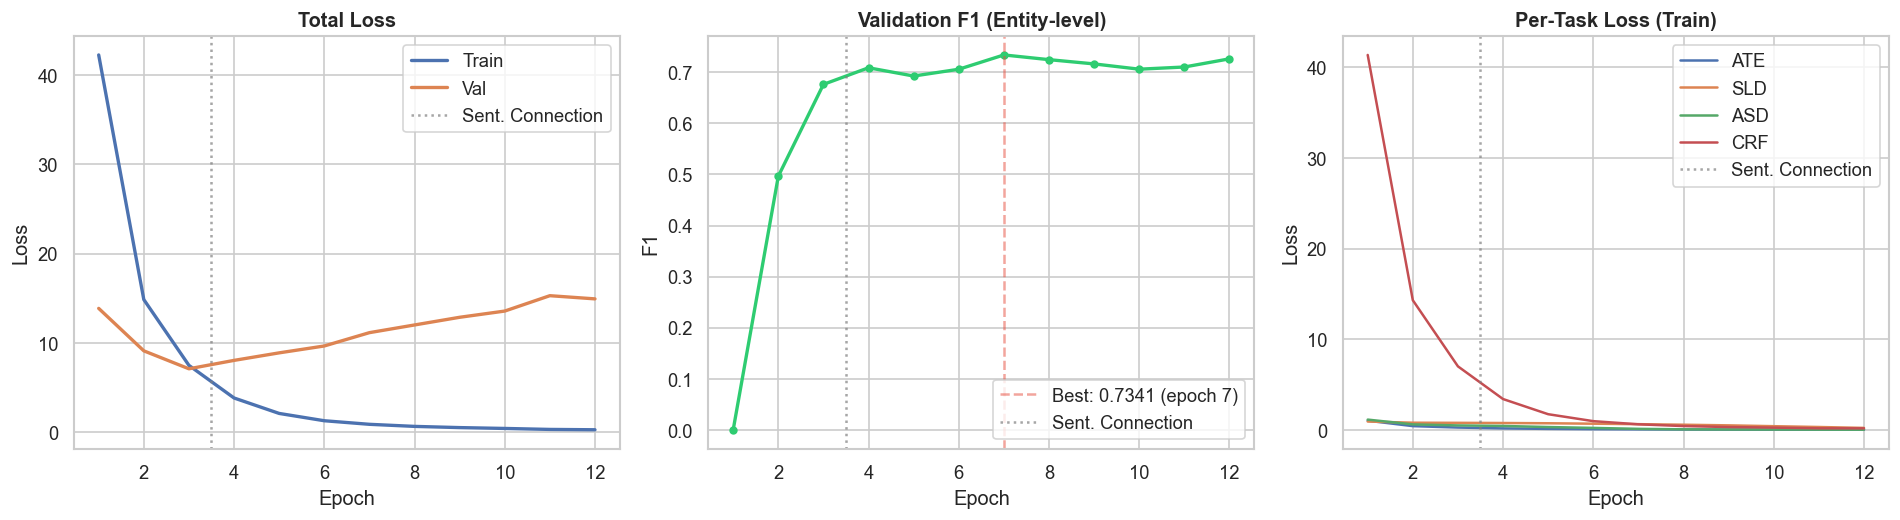

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss curves
axes[0].plot(epochs_range, history['train_loss'], label='Train', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], label='Val', linewidth=2)
axes[0].axvline(PHASE1_EPOCHS + 0.5, color='gray', linestyle=':', alpha=0.7, label='Sent. Connection')
axes[0].set_title('Total Loss', fontweight='bold')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].legend()

# F1 curve
axes[1].plot(epochs_range, history['val_f1'], color='#2ecc71', linewidth=2, marker='o', markersize=4)
best_epoch = history['val_f1'].index(max(history['val_f1'])) + 1
axes[1].axvline(best_epoch, color='#e74c3c', linestyle='--', alpha=0.5,
                label=f'Best: {max(history["val_f1"]):.4f} (epoch {best_epoch})')
axes[1].axvline(PHASE1_EPOCHS + 0.5, color='gray', linestyle=':', alpha=0.7, label='Sent. Connection')
axes[1].set_title('Validation F1 (Entity-level)', fontweight='bold')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('F1')
axes[1].legend()

# Per-task loss
for task in ['ate', 'sld', 'asd', 'crf']:
    axes[2].plot(epochs_range, history[f'loss_{task}'], label=task.upper(), linewidth=1.5)
axes[2].axvline(PHASE1_EPOCHS + 0.5, color='gray', linestyle=':', alpha=0.7, label='Sent. Connection')
axes[2].set_title('Per-Task Loss (Train)', fontweight='bold')
axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('Loss')
axes[2].legend()

plt.tight_layout()
plt.show()

### 9. EVALUASI FINAL

In [12]:
model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'best_model_v3.pt'), weights_only=True))
val_loss, val_f1, all_true, all_preds = evaluate(model, val_loader, device)

print(f'Best Model - Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')
print(f'\n{classification_report(all_true, all_preds)}')

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Best Model - Val Loss: 11.1269, Val F1: 0.7341

              precision    recall  f1-score   support

         NEG       0.57      0.60      0.58        83
         NEU       0.58      0.58      0.58       125
         POS       0.80      0.79      0.79       536

   micro avg       0.74      0.73      0.73       744
   macro avg       0.65      0.66      0.65       744
weighted avg       0.74      0.73      0.74       744



### 10. PERBANDINGAN v1 vs v2 vs v3

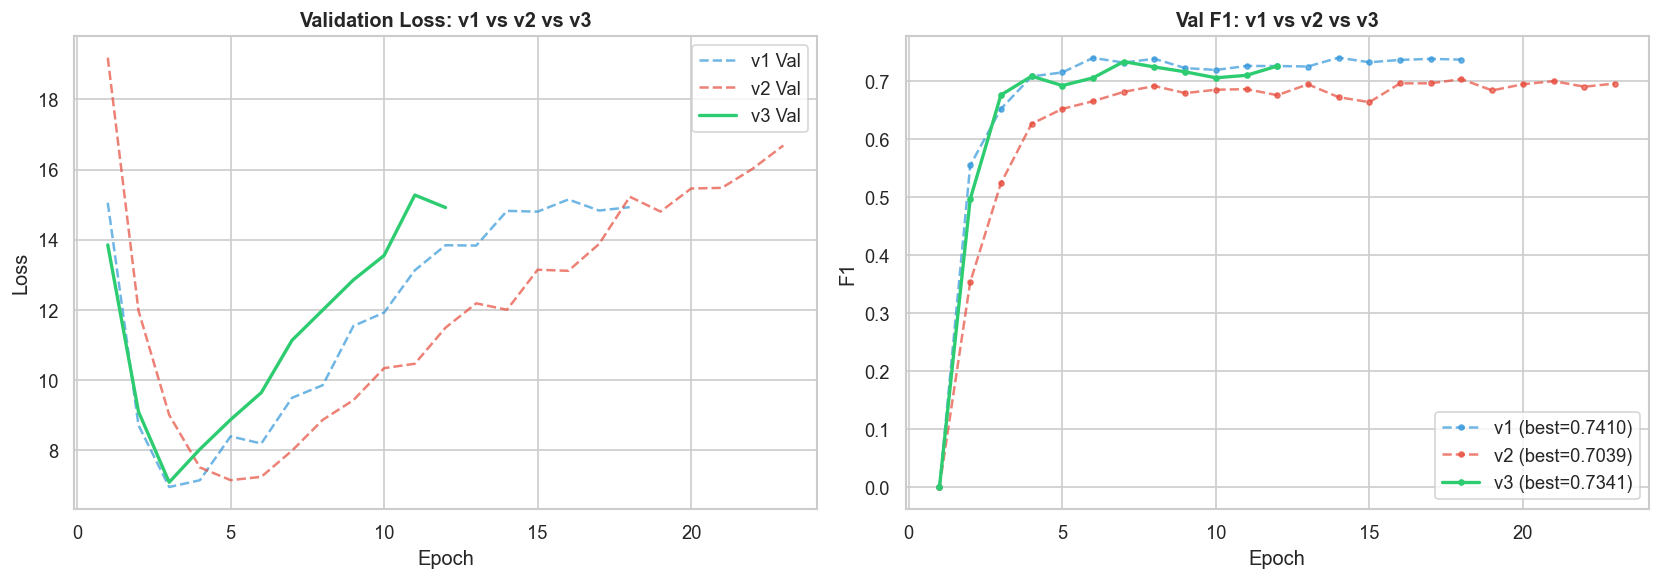


Metric                 v1 (Baseline)   v2 (Hyp.Tune)  v3 (Augmented)
Best Val F1                   0.7410          0.7039          0.7341
Epochs trained                    18              23              12
Train size                     2,083           2,083           4,290
Val size                         368             368             368


In [13]:
# Load previous checkpoints for comparison
v1_path = os.path.join(MODEL_DIR, 'checkpoint_final.pt')
v2_path = os.path.join(MODEL_DIR, 'checkpoint_v2.pt')

comparisons = {}
if os.path.exists(v1_path):
    v1 = torch.load(v1_path, weights_only=False, map_location='cpu')
    comparisons['v1'] = v1
if os.path.exists(v2_path):
    v2 = torch.load(v2_path, weights_only=False, map_location='cpu')
    comparisons['v2'] = v2

if comparisons:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    colors = {'v1': ('#3498db', '--'), 'v2': ('#e74c3c', '--'), 'v3': ('#2ecc71', '-')}

    # Loss comparison
    for name, ckpt in comparisons.items():
        h = ckpt['history']
        ep = range(1, len(h['val_loss']) + 1)
        color, style = colors[name]
        axes[0].plot(ep, h['val_loss'], style, label=f'{name} Val', color=color, alpha=0.7)

    v3_ep = range(1, len(history['val_loss']) + 1)
    axes[0].plot(v3_ep, history['val_loss'], '-', label='v3 Val', color='#2ecc71', linewidth=2)
    axes[0].set_title('Validation Loss: v1 vs v2 vs v3', fontweight='bold')
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
    axes[0].legend()

    # F1 comparison
    for name, ckpt in comparisons.items():
        h = ckpt['history']
        ep = range(1, len(h['val_f1']) + 1)
        color, style = colors[name]
        axes[1].plot(ep, h['val_f1'], style + 'o', label=f'{name} (best={ckpt["best_f1"]:.4f})',
                     color=color, alpha=0.7, markersize=3)

    axes[1].plot(v3_ep, history['val_f1'], '-o', label=f'v3 (best={best_f1:.4f})',
                 color='#2ecc71', linewidth=2, markersize=3)
    axes[1].set_title('Val F1: v1 vs v2 vs v3', fontweight='bold')
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('F1')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # Summary table
    print(f'\n{"Metric":<20} {"v1 (Baseline)":>15} {"v2 (Hyp.Tune)":>15} {"v3 (Augmented)":>15}')
    print('=' * 67)
    v1_f1 = comparisons.get('v1', {}).get('best_f1', '-')
    v2_f1 = comparisons.get('v2', {}).get('best_f1', '-')
    print(f'{"Best Val F1":<20} {v1_f1:>15.4f} {v2_f1:>15.4f} {best_f1:>15.4f}')

    v1_ep = len(comparisons.get('v1', {}).get('history', {}).get('train_loss', []))
    v2_ep = len(comparisons.get('v2', {}).get('history', {}).get('train_loss', []))
    v3_ep = len(history['train_loss'])
    print(f'{"Epochs trained":<20} {v1_ep:>15} {v2_ep:>15} {v3_ep:>15}')
    print(f'{"Train size":<20} {"2,083":>15} {"2,083":>15} {len(train_raw):>15,}')
    print(f'{"Val size":<20} {"368":>15} {"368":>15} {len(val_raw):>15}')
else:
    print('Previous checkpoints not found')

### 11. SIMPAN MODEL & CONFIG

In [14]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'model_name': MODEL_NAME,
    'max_length': MAX_LENGTH,
    'proj_dim': PROJ_DIM,
    'dropout': DROPOUT,
    'freeze_layers': FREEZE_LAYERS,
    'bieos_label2id': bieos_label2id,
    'bieos_id2label': bieos_id2label,
    'ate_labels': ate_labels,
    'sld_labels': sld_labels,
    'asd_labels': asd_labels,
    'best_f1': best_f1,
    'history': history,
    'early_stopped_epoch': len(history['train_loss']),
    'data_source': 'augmented (pre-split, no leakage)',
    'train_size': len(train_raw),
    'val_size': len(val_raw),
    'config': {
        'architecture': 'Paper-aligned (cross-attention, prior embedding, sentiment connection)',
        'dropout': DROPOUT,
        'weight_decay': WEIGHT_DECAY,
        'freeze_layers': f'{FREEZE_LAYERS}/24',
        'early_stopping': f'patience={EARLY_STOP_PATIENCE}',
        'asd_class_weights': 'none (augmentasi handle imbalance)',
        'augmentation': 'NEG x3, NEU x2 + O-token perturbation (train only)',
        'lambda1': LAMBDA1,
        'lambda2': LAMBDA2,
        'phase1_epochs': PHASE1_EPOCHS,
        'max_relative_position': MAX_REL_POS,
    }
}

save_path = os.path.join(MODEL_DIR, 'checkpoint_v3.pt')
torch.save(checkpoint, save_path)

file_size = os.path.getsize(save_path) / (1024**2)
print(f'Checkpoint saved: {save_path}')
print(f'File size: {file_size:.1f} MB')
print(f'Best F1: {best_f1:.4f}')
print(f'Train: {len(train_raw)} (augmented) | Val: {len(val_raw)} (original)')
print(f'Stopped at epoch: {len(history["train_loss"])}')
print(f'  Phase 1: {PHASE1_EPOCHS} epochs')
print(f'  Phase 2: {len(history["train_loss"]) - PHASE1_EPOCHS} epochs')

Checkpoint saved: d:\Kuliah\TA\Notebook\models\checkpoint_v3.pt
File size: 1282.0 MB
Best F1: 0.7341
Train: 4290 (augmented) | Val: 368 (original)
Stopped at epoch: 12
  Phase 1: 3 epochs
  Phase 2: 9 epochs
